# ✅ Install dependencies

In [1]:
!pip install tensorflow
# To install Keras
!pip install -q tensorflow keras keras-cv

import tensorflow as tf
import keras_cv

print("TensorFlow version:", tf.__version__)
print("KerasCV version:", keras_cv.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.1 MB/s eta 0:00:00
TensorFlow version: 2.18.0
KerasCV version: 0.9.0


# 📁 2. Upload and Unzip Dataset


In [3]:
from google.colab import files
import zipfile
import os

# 📤 Upload the zip file
uploaded = files.upload()

# ✅ Extract the uploaded zip
zip_path = list(uploaded.keys())[0]  # Get uploaded filename
extract_dir = "Brain_Tumor_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


Saving Epic and CSCR hospital Dataset.zip to Epic and CSCR hospital Dataset.zip


# 🔍 Step 1: Check Folder Structure


In [4]:
# ✅ Optional: print directory structure to verify
for root, dirs, files in os.walk(extract_dir):
    print(root, "->", len(files), "files")


Brain_Tumor_Dataset -> 0 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset -> 0 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Test -> 0 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Test/pituitary -> 626 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Test/glioma -> 755 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Test/notumor -> 487 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Test/meningioma -> 546 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Train -> 0 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Train/pituitary -> 2504 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Train/glioma -> 3018 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Train/notumor -> 1945 files
Brain_Tumor_Dataset/Epic and CSCR hospital Dataset/Train/meningioma -> 2183 files


# 🗂 4. Load Images and Labels ==>Preprocess dataset (images + labels)


In [5]:
import os

image_paths = []
image_labels = []

# ✅ Correct root folder
data_root = os.path.join("Brain_Tumor_Dataset", "Epic and CSCR hospital Dataset")

# ✅ Use correct folder names: Train and Test
for split in ["Train", "Test"]:
    split_path = os.path.join(data_root, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            for fname in os.listdir(label_path):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(label_path, fname))
                    image_labels.append(label)

# ✅ Summary
classes = sorted(set(image_labels))
print("Classes:", classes)
print("Total samples:", len(image_paths))


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total samples: 12064


# 🗂 4. Load Images and Labels ==>Preprocess dataset (images + labels)


# Label Extraction Code

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Set image size (same as used in model)
IMG_SIZE = (224, 224)

# Containers
val_images = []
y_true = []

# Optional: Map label names to indices (consistent with model training)
label_to_index = {label: idx for idx, label in enumerate(sorted(set(image_labels)))}

# ✅ Loop through all images
for img_path, label in zip(image_paths, image_labels):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    val_images.append(img_array)
    y_true.append(label_to_index[label])  # Convert label to index

# Convert to NumPy arrays
val_images = np.array(val_images)
y_true = np.array(y_true)

# ✅ Summary
print("✅ Collected validation data:", val_images.shape, y_true.shape)


# 🧠 Step 3: Train the CNN-Only Baseline Model (CNN Training with Manual Data)
## This will serve as my baseline architecture (local features only — no transformer).

In [6]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array

# Constants
IMG_SIZE = (224, 224)
NUM_CLASSES = len(set(image_labels))  # e.g. 4 classes

# Map labels to numeric indices
label_to_index = {label: idx for idx, label in enumerate(sorted(set(image_labels)))}
y_numeric = [label_to_index[label] for label in image_labels]

# Split into train/validation
train_paths, val_paths, y_train_idx, y_val_idx = train_test_split(
    image_paths, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42
)

# Load images and labels into arrays
def load_images(image_list, label_list):
    images = []
    labels = []
    for img_path, label in zip(image_list, label_list):
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img) / 255.0  # normalize
        images.append(img)
        labels.append(label)
    return np.array(images), to_categorical(labels, num_classes=NUM_CLASSES)

# Load datasets
x_train, y_train = load_images(train_paths, y_train_idx)
x_val, y_val = load_images(val_paths, y_val_idx)

print("✅ Train shape:", x_train.shape, y_train.shape)
print("✅ Val shape:", x_val.shape, y_val.shape)


✅ Train shape: (301, 224, 224, 3) (301, 4)
✅ Val shape: (76, 224, 224, 3) (76, 4)


# CNN model I  can use:

In [7]:
from tensorflow.keras import layers, models

def build_cnn_only(input_shape=(224, 224, 3), num_classes=4):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


#🧠 Train Your CNN Model Now

In [8]:
cnn_model = build_cnn_only(input_shape=(224, 224, 3), num_classes=NUM_CLASSES)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=40,
    batch_size=16,
    verbose=1
)

cnn_model.save("cnn_only.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3313 - loss: 2.0605 - val_accuracy: 0.6316 - val_loss: 1.1733
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5085 - loss: 1.1466 - val_accuracy: 0.7368 - val_loss: 0.7971
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6784 - loss: 0.7960 - val_accuracy: 0.8026 - val_loss: 0.6280
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8126 - loss: 0.4909 - val_accuracy: 0.8158 - val_loss: 0.6346
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9309 - loss: 0.3170 - val_accuracy: 0.7763 - val_loss: 0.5700
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9381 - loss: 0.2259 - val_accuracy: 0.8553 - val_loss: 0.5764
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9397 - loss: 0.1952 - val_accuracy: 0.8553 - val_loss: 0.6237
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9711 - loss: 0.0961 - val_accuracy: 0.8289 - val_loss:

# Evaluate the Model

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, x_val, y_val, model_name="Model"):
    preds = model.predict(x_val)
    y_true = np.argmax(y_val, axis=1)
    y_pred = np.argmax(preds, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n🧠 {model_name} Metrics:")
    print(f"🔹 Accuracy:  {acc:.4f}")
    print(f"🔹 Precision: {prec:.4f}")
    print(f"🔹 Recall:    {rec:.4f}")
    print(f"🔹 F1 Score:  {f1:.4f}")

  # ✅ Evaluate all model
evaluate_model(cnn_model, x_val, y_val, model_name="CNN-only")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step

🧠 CNN-only Metrics:
🔹 Accuracy:  0.8421
🔹 Precision: 0.8423
🔹 Recall:    0.8421
🔹 F1 Score:  0.8419


## ✅ Code to Plot Training vs Validation Accuracy and Loss:

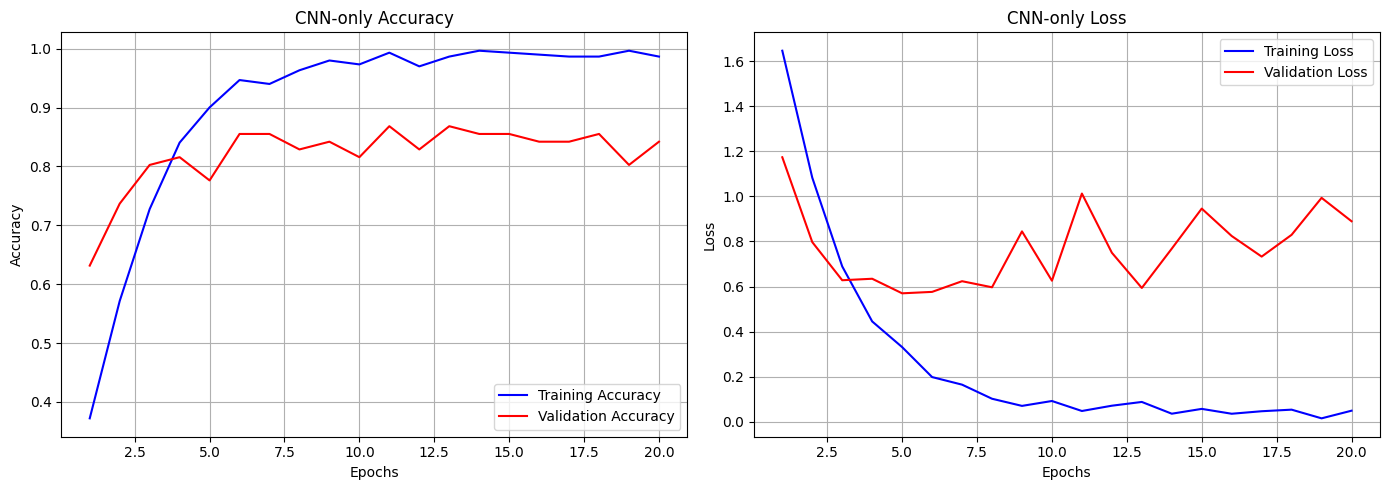

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Save the figure (for adding to paper)
    plt.tight_layout()
    plt.savefig(f"{model_name.replace(' ', '_').lower()}_training_plot.png", dpi=300)
    plt.show()

# Call the function with your CNN training history
plot_training_history(history_cnn, model_name="CNN-only")


# 🧠 Step 4: Train the ViT-Only Model
### This model captures global context using a Vision Transformer (ViT), without CNNs.

## ✅ Step 4.1: Define Patches and PatchEncoder Layers

In [11]:
from tensorflow.keras import layers

# Patch creation layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

# Patch encoder
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.position_embedding.input_dim, delta=1)
        positions = tf.expand_dims(positions, axis=0)
        positions = tf.tile(positions, [batch_size, 1])
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded


### ✅ Step 4.2: Define and Compile the ViT Model

In [12]:
from tensorflow import keras

def create_vit_classifier(input_shape=(224, 224, 3), num_classes=2,
                          patch_size=16, projection_dim=64,
                          transformer_layers=8, num_heads=4,
                          mlp_head_units=[128, 64]):

    inputs = layers.Input(shape=input_shape)

    patches = Patches(patch_size)(inputs)
    num_patches = (input_shape[0] // patch_size) ** 2
    encoded = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, encoded])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        mlp = keras.Sequential([
            layers.Dense(4 * projection_dim, activation=tf.nn.gelu),
            layers.Dense(projection_dim),
        ])
        x4 = mlp(x3)
        encoded = layers.Add()([x4, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded)
    representation = layers.Flatten()(representation)
    for units in mlp_head_units:
        representation = layers.Dense(units, activation=tf.nn.gelu)(representation)
        representation = layers.Dropout(0.1)(representation)

    outputs = layers.Dense(num_classes, activation='softmax')(representation)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

vit_model = create_vit_classifier()
vit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## ✅ Step 4.3: Train and Save the ViT Model

In [13]:
# ✅ Re-compile (if not already)
vit_model = create_vit_classifier(
    input_shape=(224, 224, 3),
    num_classes=len(set(image_labels))  # 4 classes
)

vit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train the model using manually loaded data
history_vit = vit_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=90,
    batch_size=16,
    verbose=1
)

# ✅ Save the model
vit_model.save("vit_only.h5")


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.2676 - loss: 5.0254 - val_accuracy: 0.2237 - val_loss: 2.1722
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2857 - loss: 1.9845 - val_accuracy: 0.2237 - val_loss: 1.4545
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3252 - loss: 1.5212 - val_accuracy: 0.2368 - val_loss: 1.6723
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2645 - loss: 1.5527 - val_accuracy: 0.2237 - val_loss: 1.3972
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2339 - loss: 1.4293 - val_accuracy: 0.2237 - val_loss: 1.3911
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2717 - loss: 1.4229 - val_accuracy: 0.2237 - val_loss: 1.3889
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1830 - loss: 1.4120 - val_accuracy: 0.3158 - val_loss: 1.3790
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2635 - loss: 1.3808 - val_accuracy: 0.3158 - val_loss:

# Evaluate The Model

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, x_val, y_val, model_name="Model"):
    preds = model.predict(x_val)
    y_true = np.argmax(y_val, axis=1)
    y_pred = np.argmax(preds, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n🧠 {model_name} Metrics:")
    print(f"🔹 Accuracy:  {acc:.4f}")
    print(f"🔹 Precision: {prec:.4f}")
    print(f"🔹 Recall:    {rec:.4f}")
    print(f"🔹 F1 Score:  {f1:.4f}")
# ✅ Evaluate all models
evaluate_model(vit_model, x_val, y_val, model_name="ViT-only")



3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step

🧠 ViT-only Metrics:
🔹 Accuracy:  0.3158
🔹 Precision: 0.0997
🔹 Recall:    0.3158
🔹 F1 Score:  0.1516


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## ✅ Code to Plot Training vs Validation Accuracy and Loss: fro vit only

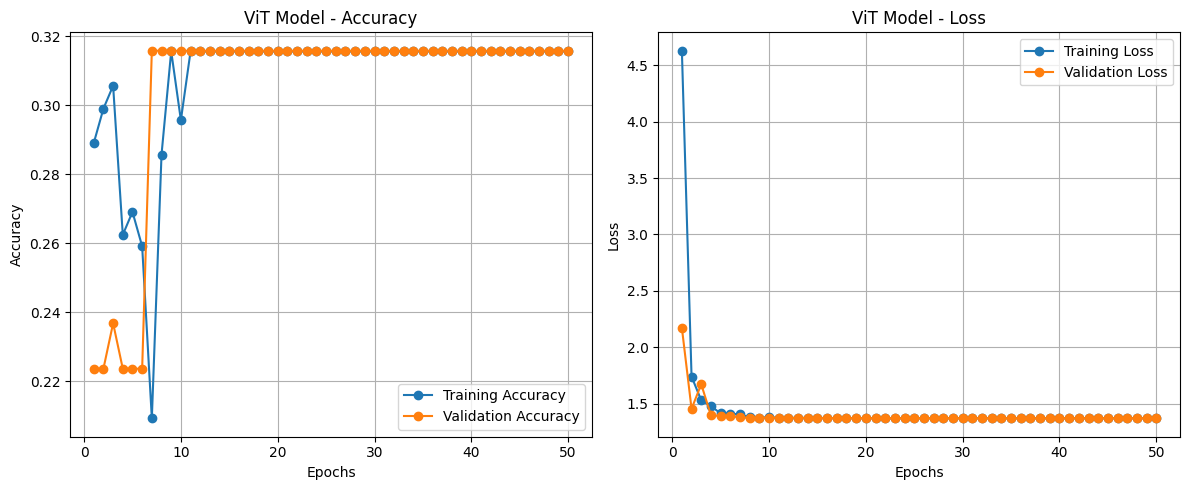

In [15]:
import matplotlib.pyplot as plt

# Extract metrics from history object
acc = history_vit.history['accuracy']
val_acc = history_vit.history['val_accuracy']
loss = history_vit.history['loss']
val_loss = history_vit.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ViT Model - Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ViT Model - Loss')
plt.legend()
plt.grid(True)

# Save and show
plt.tight_layout()
plt.savefig("vit_model_accuracy_loss.png", dpi=300)
plt.show()

#🧠 Step 5: Build and Train the Hybrid CNN + ViT Model
#### This model combines:
####    ->CNN Branch → Local feature extraction
####    ->ViT Branch → Global context extraction
####    ->No Grad-CAM/XAI yet — just the hybrid model itself.

In [16]:
from tensorflow.keras import layers, Model

def create_hybrid_cnn_vit(input_shape=(224, 224, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)

    # 🔹 CNN Branch
    x_cnn = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x_cnn = layers.MaxPooling2D((2, 2))(x_cnn)
    x_cnn = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x_cnn)
    x_cnn = layers.MaxPooling2D((2, 2))(x_cnn)
    x_cnn = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="last_cnn_layer")(x_cnn)
    x_cnn = layers.GlobalAveragePooling2D()(x_cnn)

    # 🔸 ViT Branch
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) ** 2
    patches = Patches(patch_size)(inputs)
    encoded = PatchEncoder(num_patches, projection_dim=64)(patches)

    for _ in range(4):  # Simpler transformer block for hybrid
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded)
        attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x1, x1)
        x2 = layers.Add()([attn_output, encoded])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        mlp = keras.Sequential([
            layers.Dense(4 * 64, activation='gelu'),
            layers.Dense(64),
        ])
        encoded = layers.Add()([mlp(x3), x2])

    x_vit = layers.LayerNormalization(epsilon=1e-6)(encoded)
    x_vit = layers.Flatten()(x_vit)

    # 🔗 Fusion
    combined = layers.Concatenate()([x_cnn, x_vit])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.3)(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs, outputs)
    return model


## ✅ Step 5.2: Compile and Train the Hybrid Model

In [17]:
# ✅ Build model
hybrid_model = create_hybrid_cnn_vit(
    input_shape=(224, 224, 3),
    num_classes=len(set(image_labels))  # 4 classes
)

# ✅ Compile model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Train model
history_hybrid = hybrid_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=120,          # You can adjust based on your GPU
    batch_size=16,      # Can reduce to 8 if out-of-memory
    verbose=1
)

# ✅ Save the model
hybrid_model.save("hybrid_cnn_vit.h5")


Epoch 1/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.3378 - loss: 1.9978 - val_accuracy: 0.4211 - val_loss: 1.2409
Epoch 2/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4550 - loss: 1.1985 - val_accuracy: 0.5395 - val_loss: 1.0613
Epoch 3/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6246 - loss: 1.0228 - val_accuracy: 0.6184 - val_loss: 0.9976
Epoch 4/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7622 - loss: 0.6527 - val_accuracy: 0.6842 - val_loss: 0.7212
Epoch 5/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8707 - loss: 0.4093 - val_accuracy: 0.6711 - val_loss: 0.7393
Epoch 6/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9313 - loss: 0.2671 - val_accuracy: 0.7368 - val_loss: 0.6743
Epoch 7/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9217 - loss: 0.2267 - val_accuracy: 0.7237 - val_loss: 0.6255
Epoch 8/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9886 - loss: 0.1157 - val_accuracy: 0.7763 - val_loss:

# Evaluate the Model

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, x_val, y_val, model_name="Model"):
    preds = model.predict(x_val)
    y_true = np.argmax(y_val, axis=1)
    y_pred = np.argmax(preds, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n🧠 {model_name} Metrics:")
    print(f"🔹 Accuracy:  {acc:.4f}")
    print(f"🔹 Precision: {prec:.4f}")
    print(f"🔹 Recall:    {rec:.4f}")
    print(f"🔹 F1 Score:  {f1:.4f}")

# ✅ Evaluate all models
evaluate_model(hybrid_model, x_val, y_val, model_name="Hybrid CNN + ViT")


2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step

🧠 Hybrid CNN + ViT Metrics:
🔹 Accuracy:  0.8553
🔹 Precision: 0.8611
🔹 Recall:    0.8553
🔹 F1 Score:  0.8551


## ✅ Plot Training vs Validation Accuracy and Loss (Hybrid CNN + ViT)

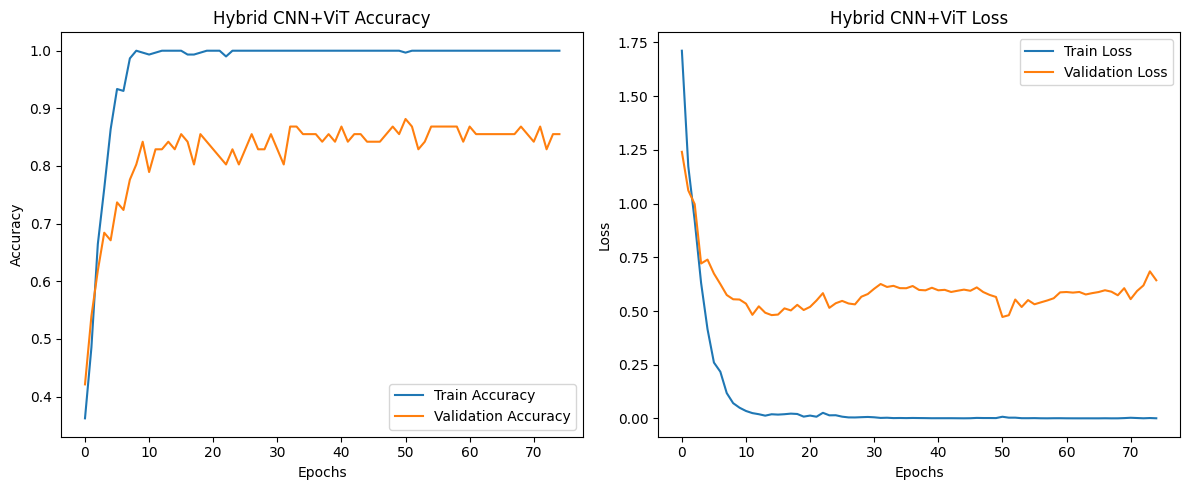

In [19]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid CNN+ViT Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Hybrid CNN+ViT Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# ✅ Metric table comparing models (Accuracy, Precision, Recall, F1)
## Here's the full code to compute Accuracy, Precision, Recall, and F1 Score for all three models: CNN-only, ViT-only, and Hybrid (CNN + ViT).

In [20]:
# ✅ Evaluate all models
evaluate_model(cnn_model, x_val, y_val, model_name="CNN-only")
evaluate_model(vit_model, x_val, y_val, model_name="ViT-only")
evaluate_model(hybrid_model, x_val, y_val, model_name="Hybrid CNN + ViT")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step

🧠 CNN-only Metrics:
🔹 Accuracy:  0.8421
🔹 Precision: 0.8423
🔹 Recall:    0.8421
🔹 F1 Score:  0.8419
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🧠 ViT-only Metrics:
🔹 Accuracy:  0.3158
🔹 Precision: 0.0997
🔹 Recall:    0.3158
🔹 F1 Score:  0.1516
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 970ms/step

🧠 Hybrid CNN + ViT Metrics:
🔹 Accuracy:  0.8553
🔹 Precision: 0.8611
🔹 Recall:    0.8553
🔹 F1 Score:  0.8551


# 🧠 Step 6: Grad-CAM for the Hybrid CNN + ViT Model
#### We’ll apply Grad-CAM on the CNN branch (last convolutional layer) to generate heatmaps that show what parts of the MRI image influenced the model's decision.

### ✅ Step 6.1: Grad-CAM Utility Function


In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_output, conv_outputs)

    # Mean intensity of the gradient over the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


### ✅ Step 6.2: Visualize Heatmap on an MRI Image

In [22]:
import cv2

def display_gradcam(model, image, label, class_names, last_conv_layer_name="last_cnn_layer"):
    # Expand dims for batch
    img_array = np.expand_dims(image, axis=0)

    # Get heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Superimpose on image
    img = image.copy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + (img * 255).astype(np.uint8)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Input Image\nLabel: {class_names[label]}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Overlay")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


### ✅ Step 6.3: Run Grad-CAM on One Sample Image

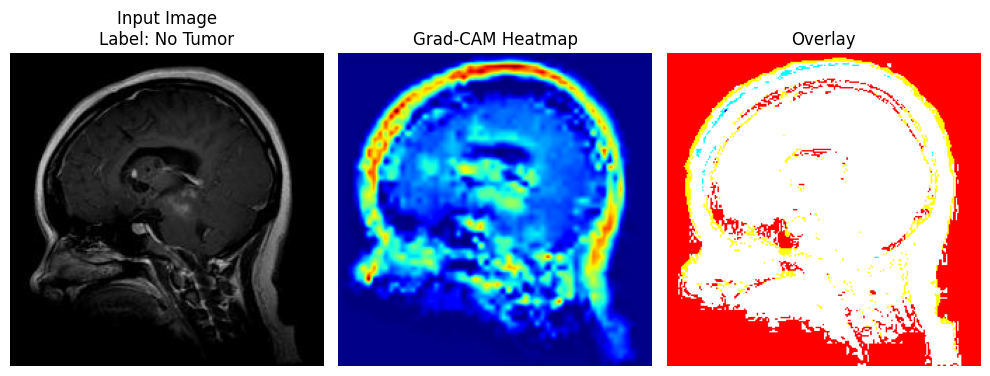

In [26]:
# Choose one image from validation set
sample_index = 13
sample_img = val_images[sample_index]
sample_label = y_true[sample_index]

# Define your class names (adjust if needed)
class_names = ["No Tumor", "Tumor"]

# Visualize
display_gradcam(model=hybrid_model, image=sample_img, label=sample_label, class_names=class_names)


## ✅ Grad-CAM Visualizations (Loop Version) ==> for 6 Sample
#### Grad-CAM Visuals (6 samples)	✅ display_gradcam() in a loop
#### Grad-CAM PNGs for paper	✅ save_gradcam_overlay() function
#### ROC Curve	✅ roc_curve() + auc() plot
#### Classification Report	✅ classification_report() table


🔍 Grad-CAM for Sample 1 — Label: No Tumor


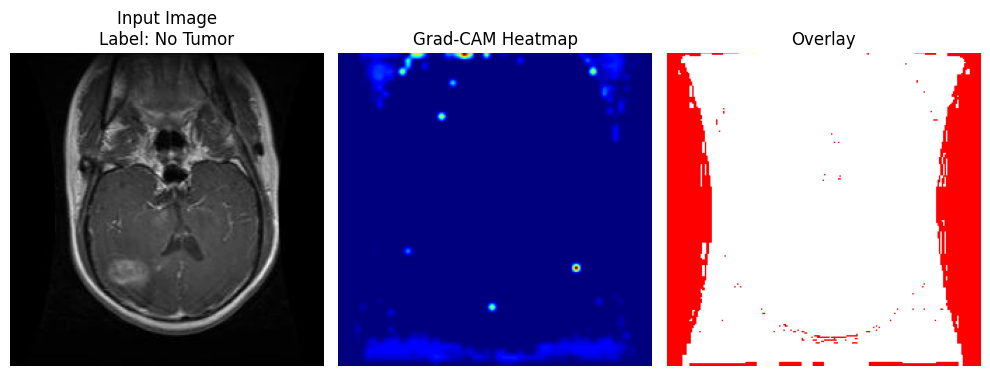


🔍 Grad-CAM for Sample 2 — Label: No Tumor


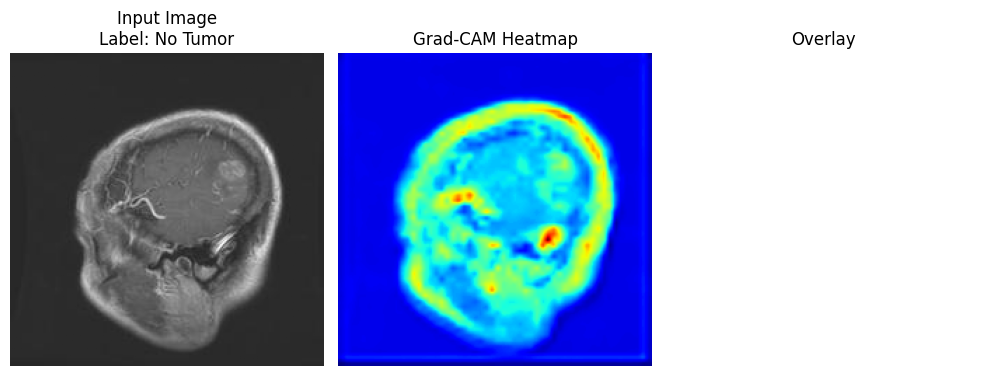


🔍 Grad-CAM for Sample 3 — Label: No Tumor


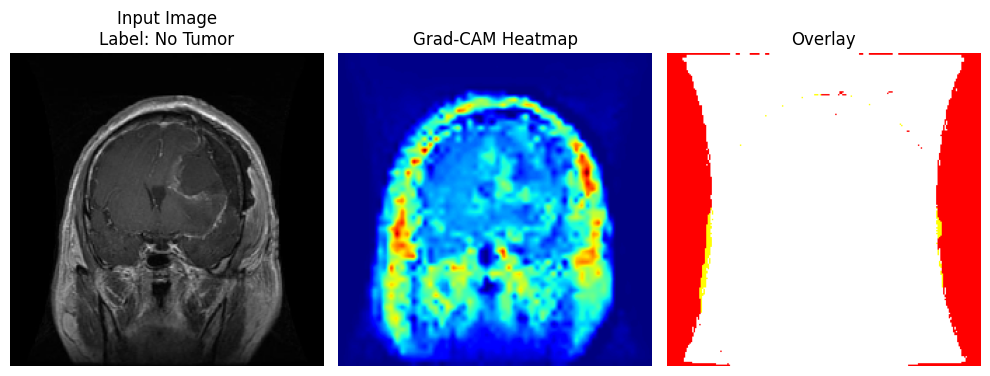


🔍 Grad-CAM for Sample 4 — Label: No Tumor


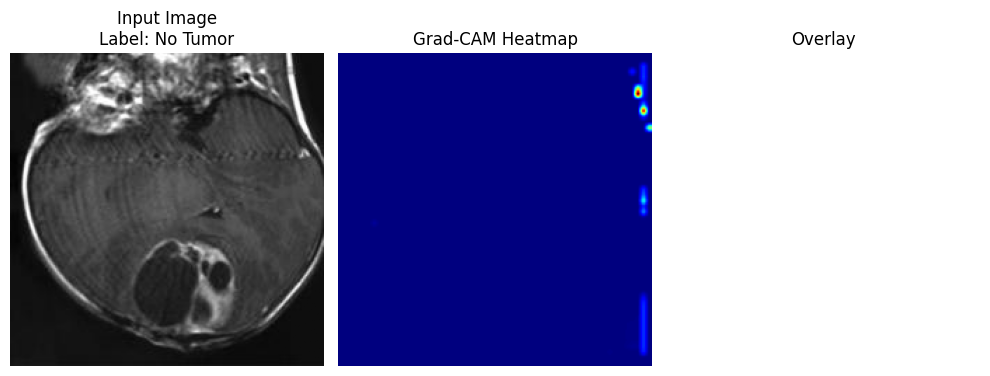


🔍 Grad-CAM for Sample 5 — Label: No Tumor


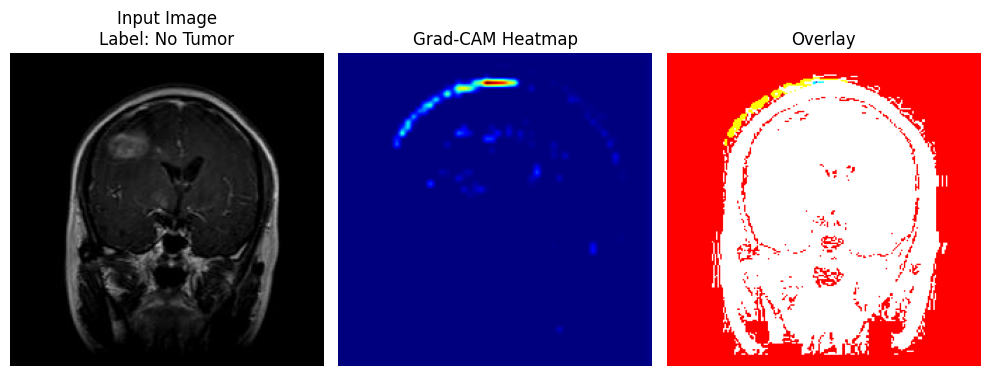


🔍 Grad-CAM for Sample 6 — Label: No Tumor


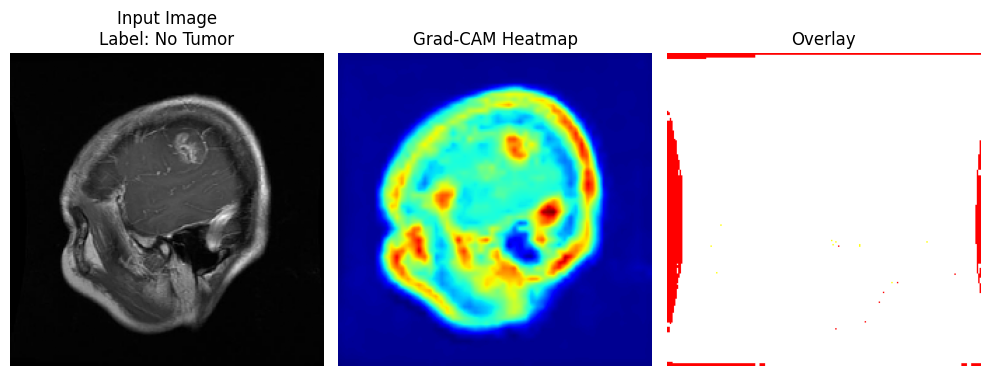

In [27]:
# 🔁 Show Grad-CAM on 6 validation samples
for i in range(6):
    sample_img = val_images[i]
    sample_label = y_true[i]

    print(f"\n🔍 Grad-CAM for Sample {i+1} — Label: {class_names[sample_label]}")
    display_gradcam(
        model=hybrid_model,
        image=sample_img,
        label=sample_label,
        class_names=class_names
    )


## ✅ [Optional] Save Grad-CAM Results as PNGs for Paper

In [28]:
def save_gradcam_overlay(model, image, label, class_names, filename, last_conv_layer_name="last_cnn_layer"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    img_array = np.expand_dims(image, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    img = image.copy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + (img * 255).astype(np.uint8)

    plt.figure(figsize=(6, 4), dpi=300)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Overlay\nLabel: {class_names[label]}")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"📸 Saved Grad-CAM to: {filename}")


In [29]:
# 🔽 Save 6 Grad-CAM overlays
for i in range(6):
    sample_img = val_images[i]
    sample_label = y_true[i]
    save_gradcam_overlay(
        model=hybrid_model,
        image=sample_img,
        label=sample_label,
        class_names=class_names,
        filename=f"ablation_results/gradcam_sample_{i+1}.png"
    )


📸 Saved Grad-CAM to: ablation_results/gradcam_sample_1.png


📸 Saved Grad-CAM to: ablation_results/gradcam_sample_2.png


📸 Saved Grad-CAM to: ablation_results/gradcam_sample_3.png


📸 Saved Grad-CAM to: ablation_results/gradcam_sample_4.png


📸 Saved Grad-CAM to: ablation_results/gradcam_sample_5.png


📸 Saved Grad-CAM to: ablation_results/gradcam_sample_6.png


# ✅ Additional Evaluation for Paper (Optional But Useful)

## 1. ROC Curve for Binary Classification

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 851ms/step


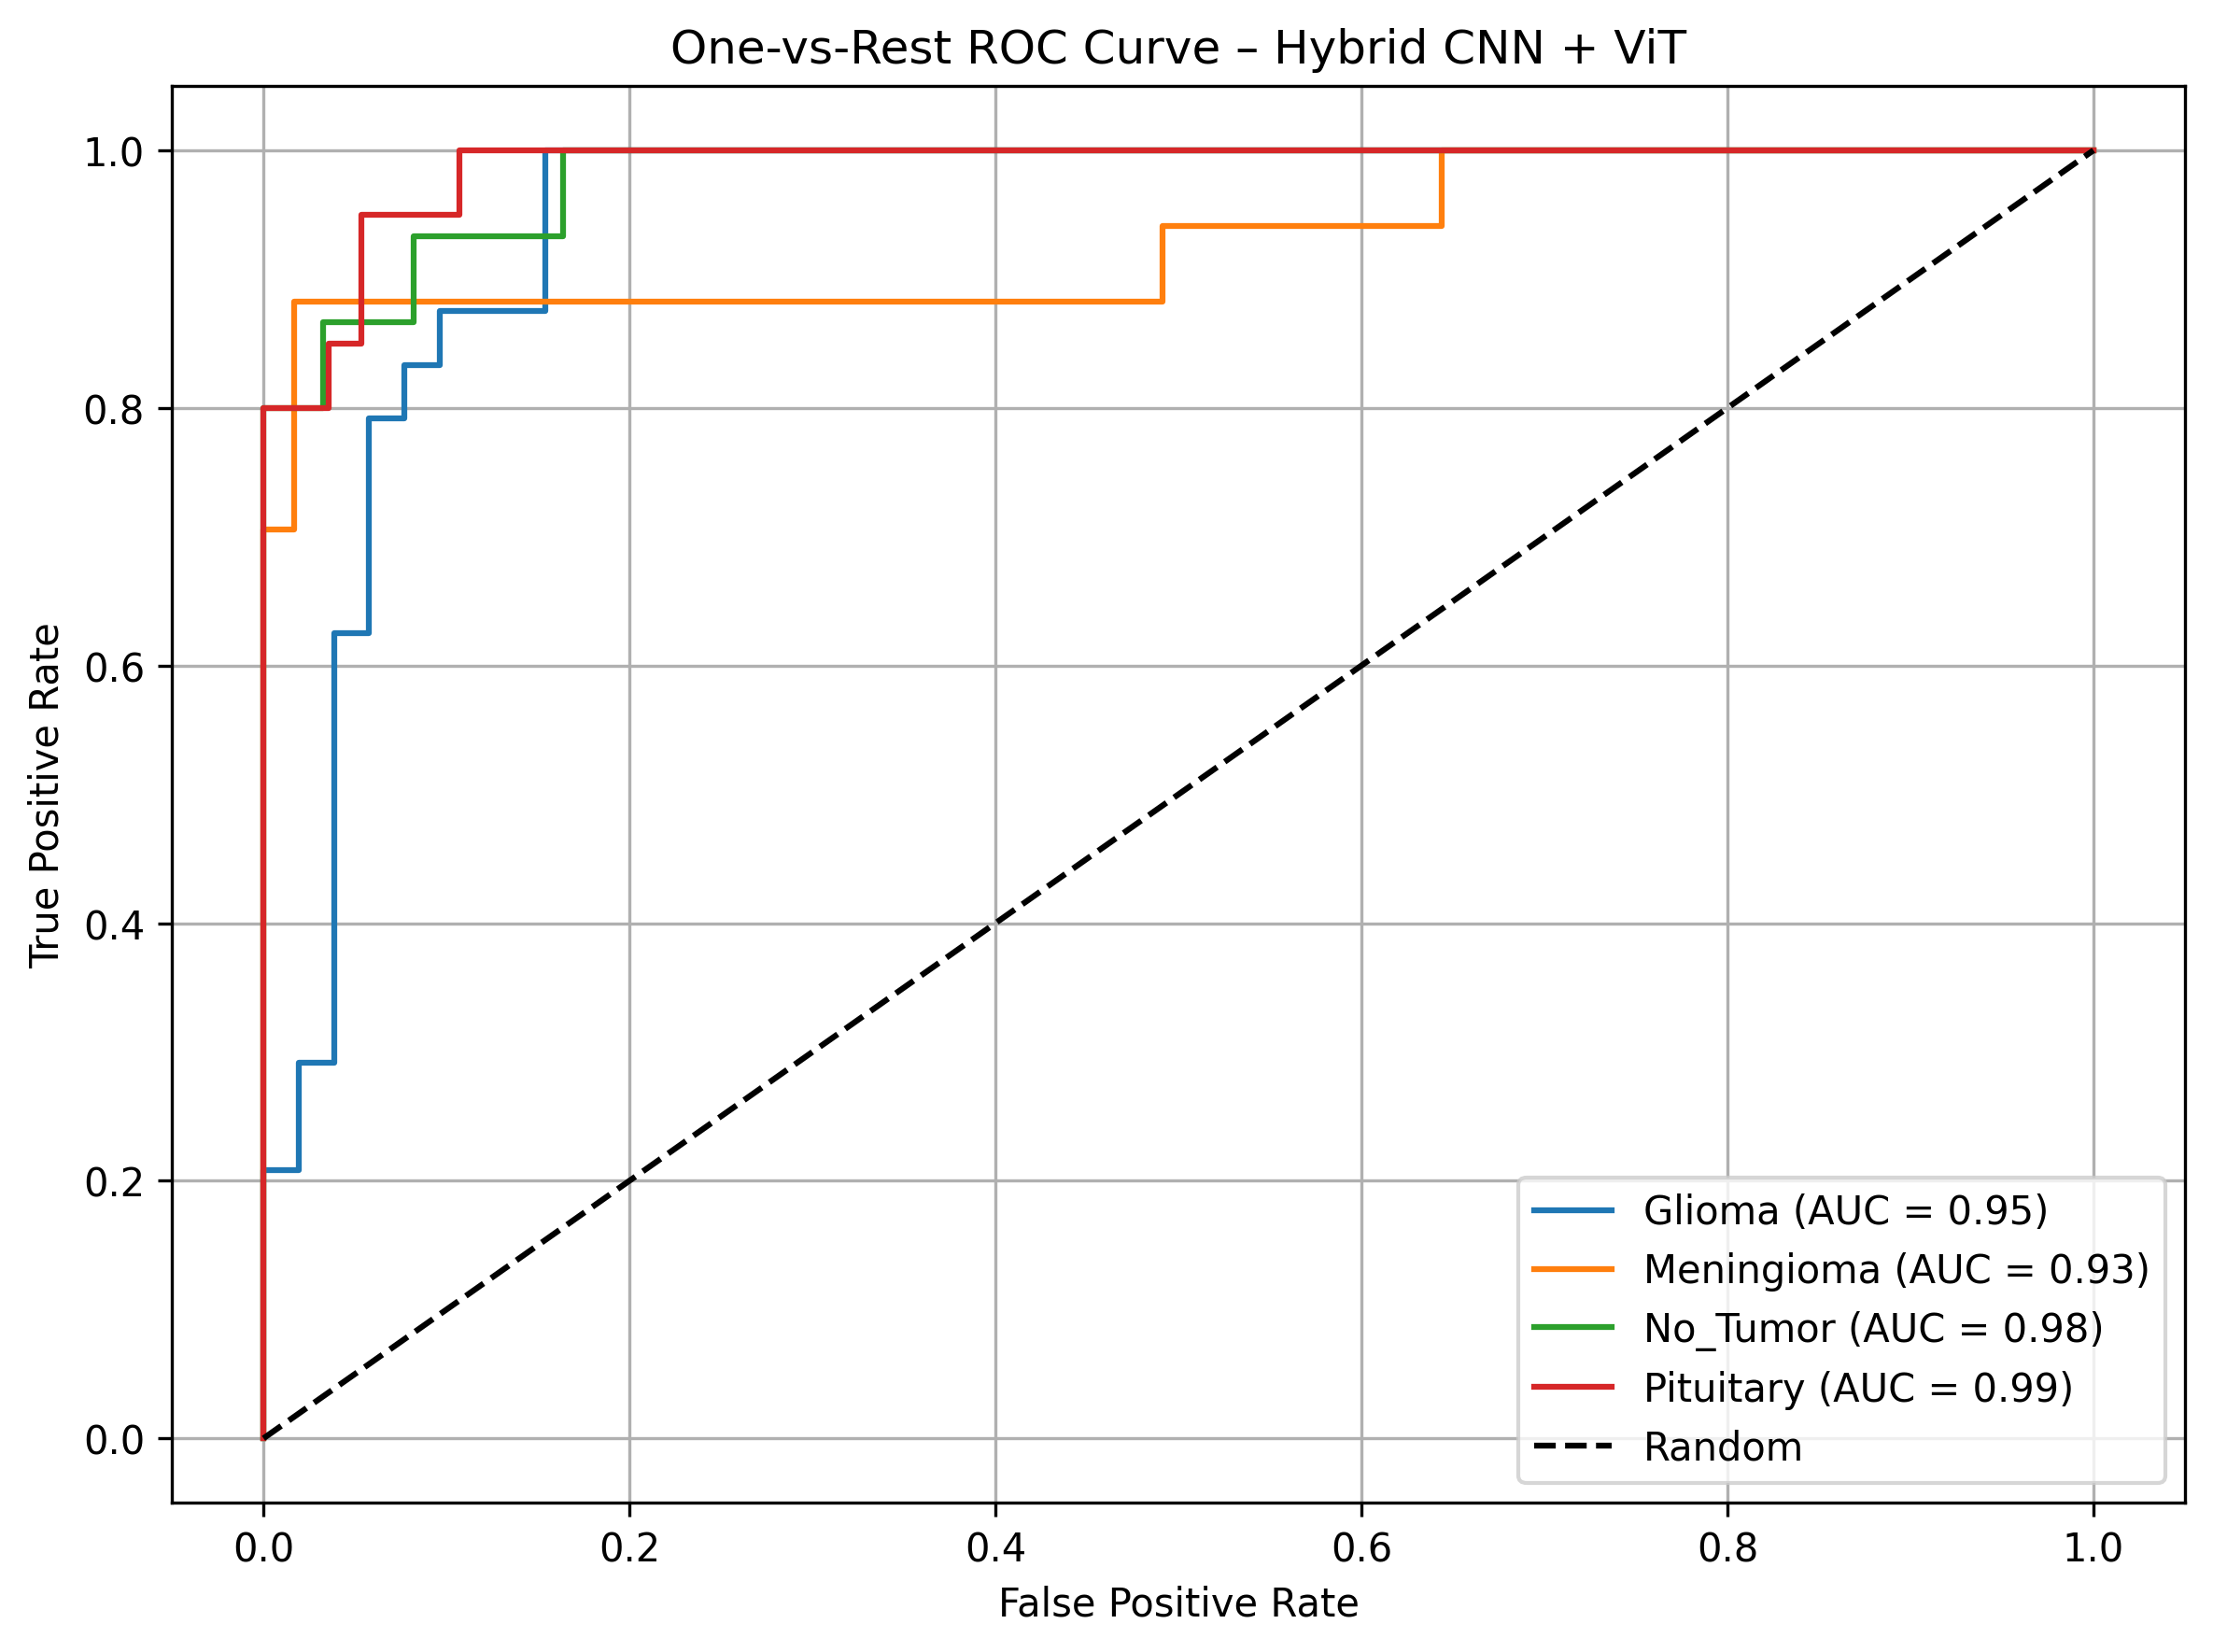

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Classes
class_names = sorted(set(image_labels))  # ['Glioma', 'Meningioma', 'No_Tumor', 'Pituitary']
n_classes = len(class_names)

# Get predictions
y_score = hybrid_model.predict(x_val)
y_true_bin = label_binarize(np.argmax(y_val, axis=1), classes=list(range(n_classes)))

# Plot ROC for each class
plt.figure(figsize=(8, 6), dpi=300)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("One-vs-Rest ROC Curve – Hybrid CNN + ViT")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_multiclass_hybrid.png", dpi=300)
plt.show()


## 2. Classification Report in Tabular Format

In [31]:
from sklearn.metrics import classification_report
import pandas as pd

y_pred = np.argmax(hybrid_model.predict(val_images, verbose=0), axis=1)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Save or display
print(df_report)
df_report.to_csv("ablation_results/classification_report_hybrid.csv")


              precision    recall  f1-score     support
Glioma         0.966102  0.957983  0.962025  119.000000
Meningioma     0.988235  0.976744  0.982456   86.000000
No_Tumor       0.986111  0.959459  0.972603   74.000000
Pituitary      0.950980  0.989796  0.970000   98.000000
accuracy       0.970822  0.970822  0.970822    0.970822
macro avg      0.972857  0.970996  0.971771  377.000000
weighted avg   0.971148  0.970822  0.970835  377.000000
